# PROJECT KELOMPOK 19
# Deteksi Penyakit pada Daun Kentang Menggunakan Pendekatan Ekstraksi Ciri

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log
import math
import cv2
from tqdm import tqdm
import pandas as pd
from math import ceil
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def tampilkanGambar(images, titles, row, col):
    plt.figure(figsize=(10,10))
    for i in range(row):
        for j in range (col):
            plt.subplot(row,col,i*col+(j+1))
            plt.grid(color="none")
            plt.imshow(images[i*col+j],'gray')
            plt.title(titles[i*col+j])
    plt.tight_layout()
    plt.show()

In [3]:
def import_dataset(dataset_path, label_names):
    dataset = []
    labels = []
    limit=100
    
    for label_index, label_name in enumerate(label_names):
        label_path = os.path.join(dataset_path, label_name)
        image_files = os.listdir(label_path)[:limit]
        
        for image_file in image_files:
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                dataset.append(image)
                labels.append(label_index)
   
    return dataset, labels

dataset_folder = 'PotatoPlants'
label_names = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
dataset, labels = import_dataset(dataset_folder, label_names)

In [4]:
def preprocess_dataset(data, labels):
    # Normalisasi
    image_size = (256, 256)
    normalized_data = []

    for image in data:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        # Resize
        image = cv2.resize(image, image_size)
        normalized_data.append(image)

    normalized_data = np.array(normalized_data, dtype='float32') / 255.0

    return normalized_data, labels

In [5]:
def sorting(arr):
    for i in range(len(arr)):
        swap = i + np.argmin(arr[i:])
        (arr[i], arr[swap]) = (arr[swap], arr[i])
    return arr

In [6]:
def flatArray(arr):
    row, col = arr.shape
    flat=[]
    for i in range (row):
        for j in range (col):
            flat.append(arr[i][j])
    return flat

In [7]:
def median(image,windowHeight,windowWidth):
    pad = np.pad(image,(windowHeight,windowWidth),mode='edge')
    median = np.zeros(image.shape, dtype=np.uint8)
    for i in range(windowHeight,len(pad)-windowHeight):
        for j in range(windowWidth,len(pad)-windowWidth):
            window = flatArray(pad[i-windowHeight:i,j-windowWidth:j])
            window = sorting(window)
            median[i-windowHeight,j-windowWidth] = window[ceil(len(window)/2)]
    return median

In [8]:
def fit(window,SE): 
    for i in range(len(SE)):
      for j in range(len(SE)):
        if(SE[i][j]==1 and window[i][j]==0): 
          return 0
    return 1
def erosi(image,SE):
    erosi = np.zeros(image.shape, dtype=np.uint8)
    row, col = image.shape
    # melakukan perulangan pada window center image
    for i in range(row-len(SE)):
        for j in range(col-len(SE)):
            window = image[i:i+len(SE),j:j+len(SE)]
            # mengambil nilai pada fungsi fit, jika fit maka bernilai 1 jika tidak maka 0
            erosi[i][j] = fit(window,SE)
    return erosi

In [9]:
def convertBinary(image):
    ret, binary = cv2.threshold(image,30,255,cv2.THRESH_BINARY)
    return binary

In [10]:
def getParasite(image):
    ret,parasit = cv2.threshold(image,118,255,cv2.THRESH_BINARY)
    parasit-=255
    return parasit

In [11]:
SE = [[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]]

In [12]:
def segmentation(mainImage, grayImage):
    parasite=getParasite(grayImage)
    erode = erosi(parasite, SE)
    medParasite = median(erode, 4, 4)
    maskParasite = cv2.bitwise_and(mainImage, mainImage, mask=medParasite)
    return maskParasite

In [13]:
def drawParasite(mainImage, parasite):
    grayParasite = cv2.cvtColor(parasite, cv2.COLOR_RGB2GRAY)
    binaryParasite = convertBinary(grayParasite)
    contours, hierarchy = cv2.findContours(binaryParasite, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    parasiteDraw = cv2.drawContours(mainImage, contours, -1, (0,255,0), 2)
    return parasiteDraw

In [14]:
kernel_smoothing = np.array([[1/9,1/9,1/9],
                             [1/9,8/9,1/9],
                             [1/9,1/9,1/9]])

def getPadding(image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2
    
    kiri = i
    kanan = (kernel.shape[1]-1)-i
    atas = j
    bawah = (kernel.shape[0]-1)-j
    
    result = np.pad(image, ((atas, bawah), (kiri, kanan)), 'edge')
    return result

def mean(image, kernel):
    result = np.zeros(image.shape).astype(int)

    imgPad = getPadding(image, kernel)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sum = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    sum += imgPad[i+k, j+l] * kernel[k,l]
                result[i, j] = sum
    return result

In [15]:
def pad_image(image, kernel_size):
    pad_width = kernel_size // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    return padded_image

def convolve(image, kernel):
    kernel_size = len(kernel)
    padded_image = pad_image(image, kernel_size)
    result = np.zeros_like(image, dtype=float)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            result[i, j] = np.sum(region * kernel)
    
    return result
def edge_detection(image, kernel1, kernel2):
    conv1 = convolve(image, kernel1)
    conv2 = convolve(image, kernel2)
    result = np.sqrt(conv1**2 + conv2**2)
    result = (result / np.max(result) * 255).astype(np.uint8)
    return result

sobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobelY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [16]:
dataset_dir = "PotatoPlants/"
images = []
labels = []
names = []

early_blight = 1
late_blight = 1
healthy = 1

# Create directories if they do not exist
os.makedirs("segmented_dataset", exist_ok=True)
os.makedirs("raw_dataset", exist_ok=True)

total_images = sum(len(files) for _, _, files in os.walk(dataset_dir))

with tqdm(total=total_images, desc="Processing images") as pbar:
    for sub_folder in os.listdir(dataset_dir):
        sub_folder_path = os.path.join(dataset_dir, sub_folder)
        if os.path.isdir(sub_folder_path):
            sub_folder_files = os.listdir(sub_folder_path)
            for i, filename in enumerate(sub_folder_files):
                file_path = os.path.join(sub_folder_path, filename)
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (255, 255))
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                max_val = np.max(gray)
                min_val = np.min(gray)
                normalisasi = np.round((gray - min_val) / (max_val - min_val))
                smoth = mean(normalisasi, kernel_smoothing)
                sobel = edge_detection(smoth, sobelX,sobelY)

                if sub_folder == 'Potato___Early_blight':
                    segmented_dataset = segmentation(img, sobel)
                    draw = drawParasite(img, segmented_dataset)

                    plt.imsave(f"segmented_dataset/Mask-{sub_folder}-{early_blight}.jpg", segmented_dataset)
                    plt.imsave(f"raw_dataset/Draw-{sub_folder}-{early_blight}.jpg", draw)

                    grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    images.append(grayParasit)
                    labels.append(sub_folder)
                    names.append(filename)

                    early_blight += 1
                elif sub_folder == 'Potato___Late_blight':
                    segmented_dataset = segmentation(img, sobel)
                    draw = drawParasite(img, segmented_dataset)

                    plt.imsave(f"segmented_dataset/Mask-{sub_folder}-{late_blight}.jpg", segmented_dataset)
                    plt.imsave(f"raw_dataset/Draw-{sub_folder}-{late_blight}.jpg", draw)

                    grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    images.append(grayParasit)
                    labels.append(sub_folder)
                    names.append(filename)

                    late_blight += 1
                else:
                    segmented_dataset = segmentation(img, sobel)
                    draw = drawParasite(img, segmented_dataset)

                    plt.imsave(f"segmented_dataset/Mask-{sub_folder}-{healthy}.jpg", segmented_dataset)
                    plt.imsave(f"raw_dataset/Draw-{sub_folder}-{healthy}.jpg", draw)

                    grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    images.append(grayParasit)
                    labels.append(sub_folder)
                    names.append(filename)

                    healthy += 1

                pbar.update(1)

images = np.array(images)
labels = np.array(labels)
names = np.array(names)

Processing images: 100%|██████████| 300/300 [36:03<00:00,  7.21s/it]


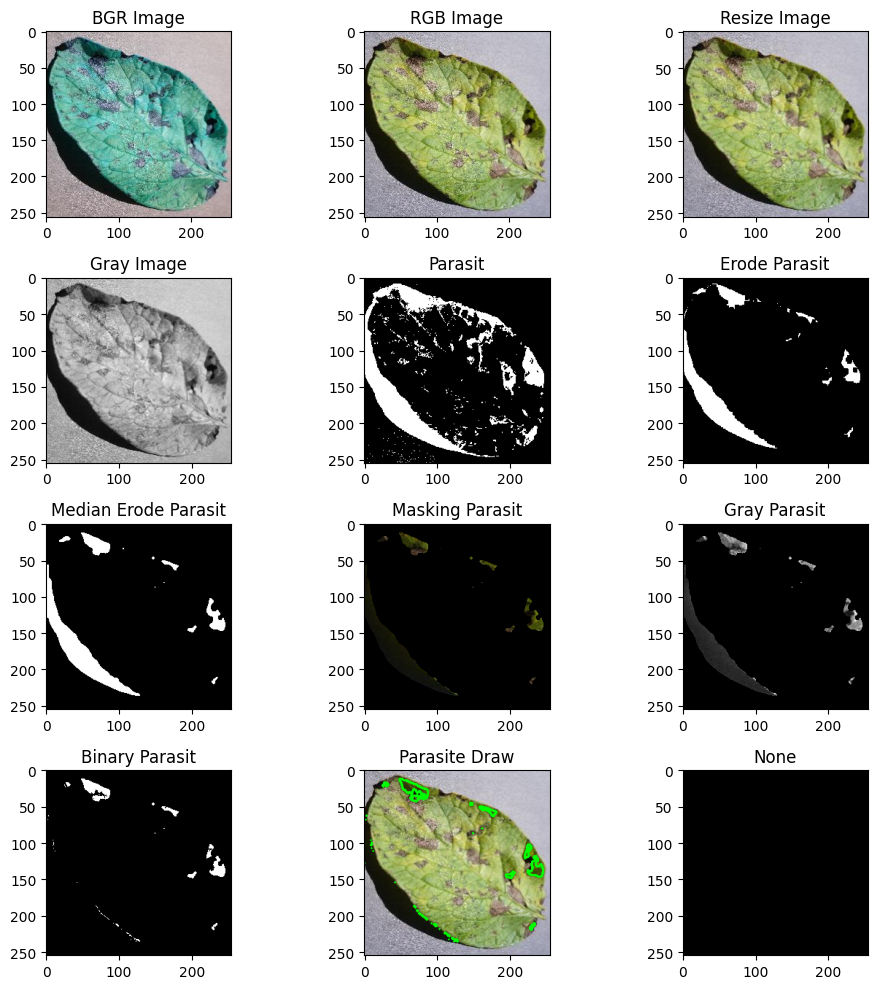

In [17]:
imgBGR = cv2.imread('PotatoPlants/Potato___Early_blight/early_blight (1).JPG')
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
img = cv2.resize(imgRGB, (255,255))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
parasite=getParasite(gray)
erode = erosi(parasite, SE)
medParasite = median(erode, 4, 4)
maskParasite = cv2.bitwise_and(img, img, mask=medParasite)
grayParasite = cv2.cvtColor(maskParasite, cv2.COLOR_RGB2GRAY)
binaryParasite = convertBinary(grayParasite)
contours, hierarchy = cv2.findContours(binaryParasite, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
parasiteDraw = cv2.drawContours(img, contours, -1, (0,255,0), 2)
none = np.zeros(img.shape)
img = cv2.resize(imgRGB, (255,255))
titles = ['BGR Image','RGB Image', 'Resize Image',
    'Gray Image', 'Parasit', 'Erode Parasit',
    'Median Erode Parasit', 'Masking Parasit', 'Gray Parasit',
    'Binary Parasit', 'Parasite Draw', 'None']
hasilimage = [imgBGR,imgRGB, img,
    gray, parasite, erode,
    medParasite, maskParasite, grayParasite,
    binaryParasite, parasiteDraw, none]
tampilkanGambar(hasilimage, titles, 4, 3)

In [18]:
def transpose(matrix):
    matrix_transpose = []
    row,col = matrix.shape
    for i in range(row):
        mRow = []
        for j in range(col):
            mRow.append(matrix[j][i])
        matrix_transpose.append(mRow)
    return matrix_transpose

def dataSum(image):
    result = 0
    for i in range (len(image)):
        for j in range(len(image)):
            result+=image[i,j]
    return result

def normalization(image):
    row, col = image.shape
    n = dataSum(image)
    for i in range(row):
        for j in range(col):
            image[i,j]/=n
    return image

def cooccurance (image, dimention, degree):
    row, col = image.shape
    matrixCo = np.zeros([dimention+1,dimention+1])
    if(degree == 0):
        for i in range(row):
            for j in range(col):
                if(j+1 < col):
                    matrixCo[image[i,j], image[i,j+1]] += 1
    elif (degree == 45):
        for i in range(row):
            for j in range(col):
                if(i-1 >= 0 and j+1 < col):
                    matrixCo[image[i,j], image[i-1,j+1]] += 1
    elif (degree == 90):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j]] += 1
    elif (degree == 135):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j+1]] += 1
    trans = transpose(matrixCo)
    sumMatrix = matrixCo+trans
    glcm = normalization(sumMatrix)
    return glcm

In [19]:
def mean(image):
    meanX=meanY= 0
    for i in range (len(image)):
        for j in range(len(image)):
            meanX += i * image[i,j]
            meanY += j * image[i,j]
    return meanX, meanY

def tao(image):
    taoX=taoY=0
    meanX,meanY= mean(image)
    for i in range (len(image)):
        for j in range(len(image)):
            taoX += pow((i-meanX),2)*image[i,j]
            taoY += pow((j-meanY),2)*image[i,j]
    return taoX, taoY

def extraction(image):
    energy=homogenity=entropy=contrast=disimilarity=correlation=ASM=0
    meanX, meanY = mean(image)
    taoX, taoY = tao(image)
    for i in range (len(image)):
        for j in range (len(image)):
            contrast += image[i,j]*pow((i-j),2)
            disimilarity += image[i,j]*abs(i-j)
            homogenity += image[i,j]/1+abs(i-j)
            if image[i,j] > 0:
                entropy += -(image[i,j] * log(image[i,j]))
            ASM += pow(image[i,j],2)
            correlation+=((i-meanX)*(j-meanY)*image[i,j])/pow((taoX*taoY),1/2)
    energy = pow(ASM, 1/2)
    return contrast,disimilarity,homogenity,entropy,ASM,energy,correlation

In [20]:
def getGLCM(images):
    glcmImage = []
    for i in tqdm(range(len(images)), desc="Calculating GLCM"):
        glcm = []
        max_val = images[i].max()
        glcm.append(cooccurance(images[i], max_val, 0))
        glcm.append(cooccurance(images[i], max_val, 45))
        glcm.append(cooccurance(images[i], max_val, 90))
        glcm.append(cooccurance(images[i], max_val, 135))
        glcmImage.append(glcm)
    return glcmImage

glcm_images = getGLCM(images)

csv = []
for index in tqdm(range(len(glcm_images)), desc="Extracting features"):
    i = glcm_images[index]
    extract = []
    extract.append(names[index])
    extract.append(labels[index])
    for img in i:
        contrast, disimilarity, homogenity, entropy, ASM, energy, correlation = extraction(img)
        extract.append(contrast)
        extract.append(disimilarity)
        extract.append(homogenity)
        extract.append(entropy)
        extract.append(ASM)
        extract.append(energy)
        extract.append(correlation)
    csv.append(extract)


Extracting features: 100%|██████████| 300/300 [03:54<00:00,  1.28it/s]


In [21]:
headerKentang = ['Name','Label','Contrast0','Dissimilarity0','Homogenity0','Entropy0','ASM0','Energy0','Correlation0'
           ,'Contrast45','Dissimilarity45','Homogenity45','Entropy45','ASM45','Energy45','Correlation45'
           ,'Contrast90','Dissimilarity90','Homogenity90','Entropy90','ASM90','Energy90','Correlation90'
           ,'Contrast135','Dissimilarity135','Homogenity135','Entropy135','ASM135','Energy135','Correlation135']
df = pd.DataFrame(csv, columns=headerKentang)

In [22]:
df.to_csv(r'hasilkentang2.csv', index=False)

In [23]:
df

,Name,Label,Contrast0,Dissimilarity0,Homogenity0,Entropy0,ASM0,Energy0,Correlation0,Contrast45,...,ASM90,Energy90,Correlation90,Contrast135,Dissimilarity135,Homogenity135,Entropy135,ASM135,Energy135,Correlation135
0,early_blight (1).JPG,Potato___Early_blight,286.185379,9.145422,4.437273e+06,7.185455,0.044259,0.210379,0.926707,499.296361,...,0.043174,0.207783,0.919921,385.529187,11.166300,4.437273e+06,7.374500,0.037493,0.193631,0.901469
1,early_blight (10).JPG,Potato___Early_blight,289.665061,9.128022,5.022993e+06,7.487288,0.033862,0.184018,0.922275,413.533341,...,0.032892,0.181362,0.908771,519.518523,12.786301,5.022993e+06,7.766107,0.025119,0.158488,0.860937
2,early_blight (100).JPG,Potato___Early_blight,507.224425,12.157511,5.146001e+06,7.547958,0.043568,0.208730,0.880363,838.535712,...,0.043704,0.209056,0.868805,666.345263,14.824710,5.146001e+06,7.732804,0.037696,0.194156,0.843071
3,early_blight (11).JPG,Potato___Early_blight,223.320642,8.088374,4.270891e+06,7.089546,0.046728,0.216167,0.852884,391.578384,...,0.042837,0.206971,0.792410,422.748651,11.826400,4.270891e+06,7.400940,0.035750,0.189076,0.721986
4,early_blight (12).JPG,Potato___Early_blight,243.396140,8.794843,5.084249e+06,7.622613,0.023503,0.153307,0.902279,366.254340,...,0.023335,0.152758,0.898113,362.645809,11.342411,5.084249e+06,7.853840,0.018624,0.136468,0.854121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,late_blight (95).JPG,Potato___Late_blight,487.770619,10.310653,4.724083e+06,7.362466,0.037476,0.193588,0.910810,740.643360,...,0.037091,0.192589,0.915347,611.743691,12.302809,4.724083e+06,7.567470,0.032221,0.179502,0.888255
296,late_blight (96).JPG,Potato___Late_blight,305.494951,8.058175,2.179673e+06,7.025296,0.037607,0.193925,0.867529,542.992854,...,0.035717,0.188989,0.817998,536.947439,12.490560,2.179673e+06,7.391659,0.029464,0.171649,0.767081
297,late_blight (97).JPG,Potato___Late_blight,351.990459,8.663610,2.179673e+06,7.308410,0.034163,0.184832,0.891132,579.346255,...,0.032776,0.181040,0.853165,609.196463,12.779605,2.179673e+06,7.625484,0.026656,0.163266,0.811638
298,late_blight (98).JPG,Potato___Late_blight,299.062683,9.473800,3.501081e+06,7.520070,0.024741,0.157292,0.819306,389.890198,...,0.025575,0.159922,0.829283,433.543261,11.976672,3.501081e+06,7.728895,0.019304,0.138940,0.738716


In [3]:
df = pd.read_csv('hasilkentang2.csv')

y = df['Label']
X = df.drop(['Label', 'Name'], axis = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

In [4]:
def min_max_scaling(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_train_normalized = min_max_scaling(X_train)
X_test_normalized = min_max_scaling(X_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_normalized, y_train)
knn_pred = knn_model.predict(X_test_normalized)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("K-Nearest Neighbors (KNN) Accuracy:", round(knn_accuracy *100),'%')

svm_model = SVC()
svm_model.fit(X_train_normalized, y_train)
svm_pred = svm_model.predict(X_test_normalized)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine (SVM) Accuracy:", round(svm_accuracy*100),'%')

rf_model = RandomForestClassifier()
rf_model.fit(X_train_normalized, y_train)
rf_pred = rf_model.predict(X_test_normalized)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", round(rf_accuracy*100),'%')

K-Nearest Neighbors (KNN) Accuracy: 79 %
Support Vector Machine (SVM) Accuracy: 87 %
Random Forest Accuracy: 77 %


In [12]:
from sklearn.metrics import classification_report, confusion_matrix


print("Evaluation for K-Nearest Neighbors (KNN):")
print(classification_report(y_test, knn_pred))
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
print("Confusion Matrix for KNN:")
print(knn_conf_matrix)

print("\nEvaluation for Support Vector Machine (SVM):")
print(classification_report(y_test, svm_pred))
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix for SVM:")
print(svm_conf_matrix)

print("\nEvaluation for Random Forest:")
print(classification_report(y_test, rf_pred))
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)


Evaluation for K-Nearest Neighbors (KNN):
                       precision    recall  f1-score   support

Potato___Early_blight       0.76      0.96      0.85        23
 Potato___Late_blight       0.78      0.86      0.82        29
     Potato___healthy       0.86      0.52      0.65        23

             accuracy                           0.79        75
            macro avg       0.80      0.78      0.77        75
         weighted avg       0.80      0.79      0.78        75

Confusion Matrix for KNN:
[[22  1  0]
 [ 2 25  2]
 [ 5  6 12]]

Evaluation for Support Vector Machine (SVM):
                       precision    recall  f1-score   support

Potato___Early_blight       0.91      0.91      0.91        23
 Potato___Late_blight       0.81      0.90      0.85        29
     Potato___healthy       0.90      0.78      0.84        23

             accuracy                           0.87        75
            macro avg       0.88      0.86      0.87        75
         weighted avg    

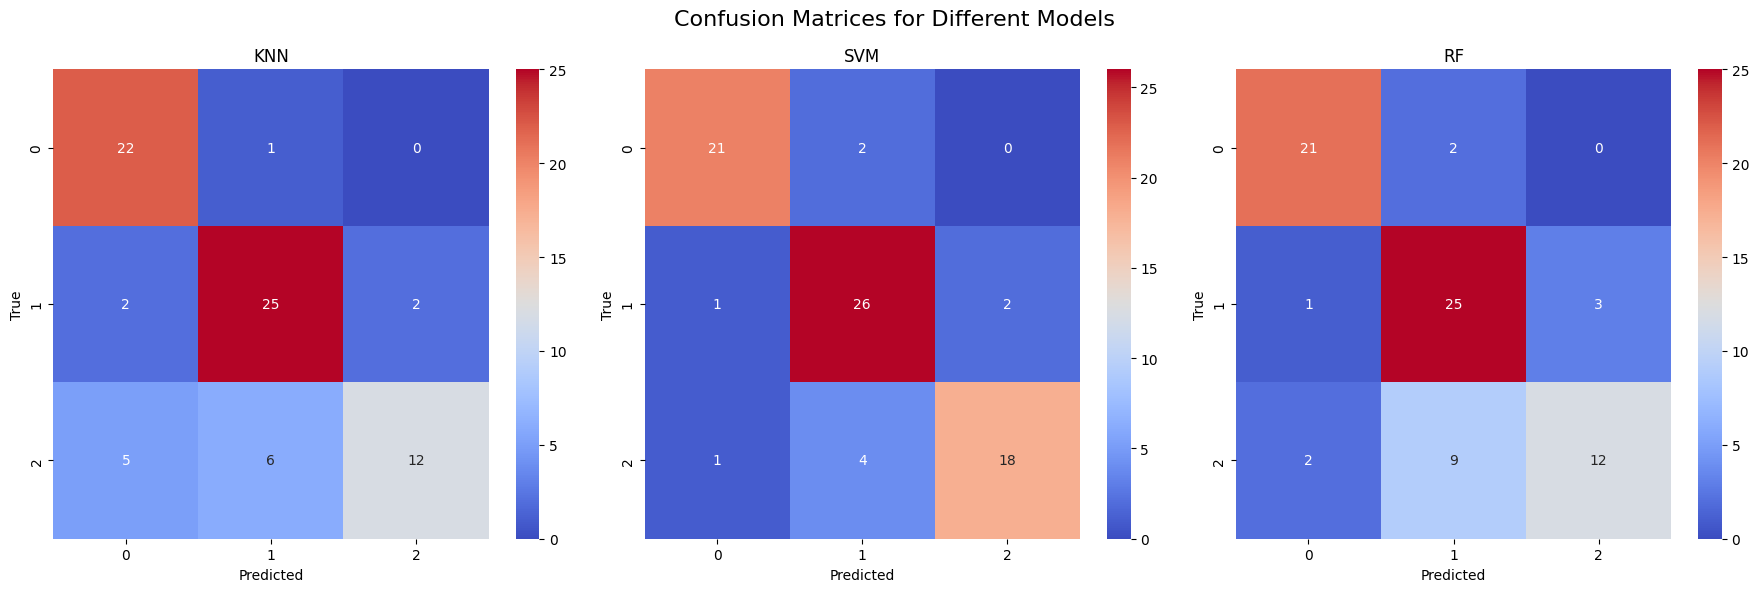

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

knn_conf_matrix = confusion_matrix(y_test, knn_pred)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[0])
axes[0].set_title('KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[1])
axes[1].set_title('SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[2])
axes[2].set_title('RF')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')


plt.tight_layout()
plt.show()